In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score
import ipywidgets as widgets #Sert pour le slider

from ipywidgets import interact,IntSlider



In [2]:
start="2020-01-01"
end="2023-12-01"

In [3]:
# Donnée Daily sur un actif

# clean_cols :Enleve la ligne Ticker (avant : structure dataframe dans un dataframe)
def clean_cols(df): # Nettoie les colonnes multi-index de yfinance

    df.columns = [c[0] for c in df.columns]
    return df

VIX=clean_cols(yf.download("^VIX",start, end))
sp500_v=clean_cols(yf.download("^GSPC",start, end))
sp500_v.head()



C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\2393538454.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX=clean_cols(yf.download("^VIX",start, end))
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\2393538454.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_v=clean_cols(yf.download("^GSPC",start, end))
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000


# I. Observation Générales

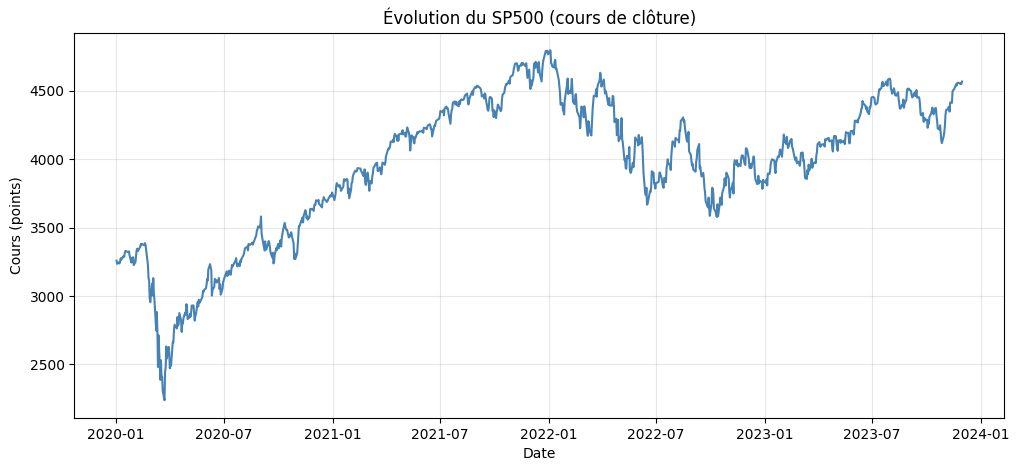

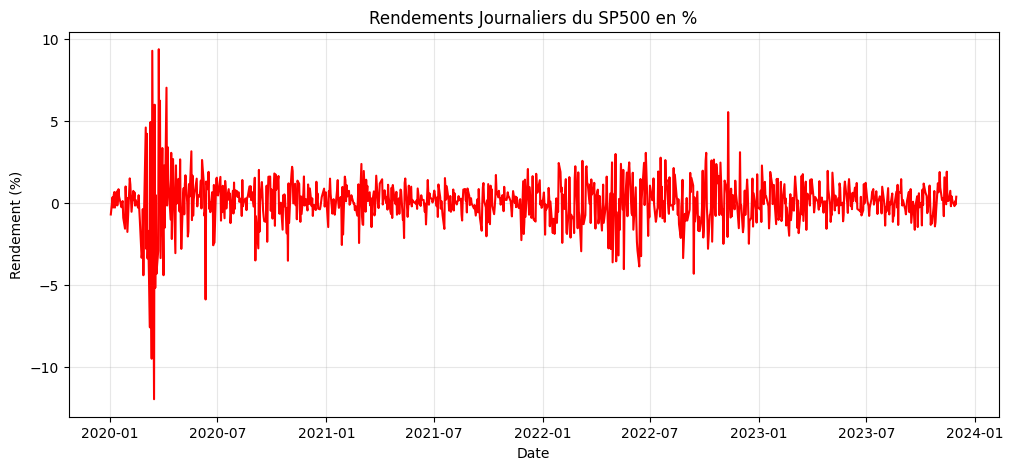

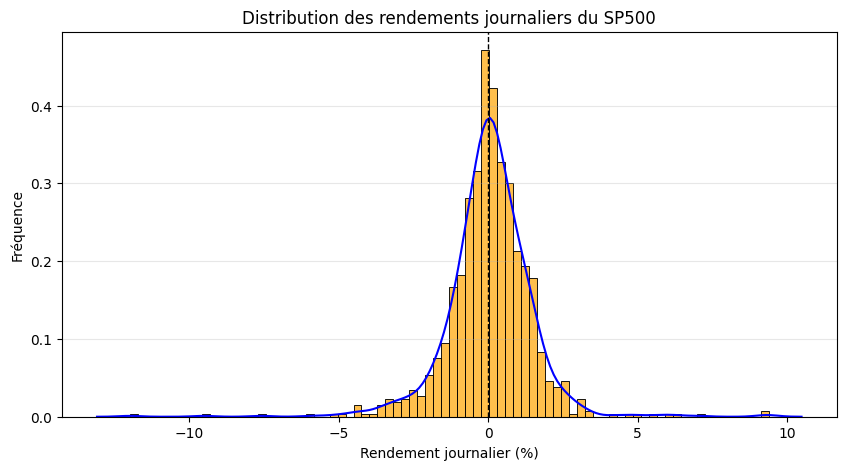

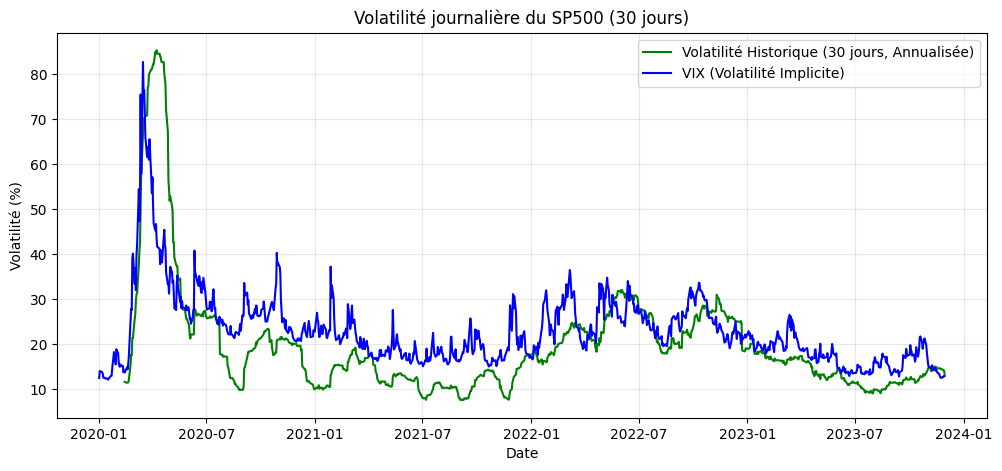

In [4]:
# Visualisation du cours de clôture SP500
plt.figure(figsize=(12,5))
plt.plot(sp500_v["Close"], color="steelblue")
plt.title("Évolution du SP500 (cours de clôture)")
plt.xlabel("Date")
plt.ylabel("Cours (points)")
plt.grid(True, alpha=0.3)
plt.show()


#Visualisations Rendements
plt.figure(figsize=(12,5))
sp500_v["rendements"]= (sp500_v["Close"]-sp500_v["Close"].shift(1))/sp500_v["Close"].shift(1)*100 #Rendements journaliers en % et Shift(1) pour décaler d'un jour
sp500_v=sp500_v.dropna() # On enlève les NaN générés par le shift (on eleve la premiere donnée)
plt.plot(sp500_v["rendements"],color="red")
plt.title("Rendements Journaliers du SP500 en %")
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.grid(True, alpha=0.3) # alpha pour la transparence
plt.show()

#Histogramme avec KDE (Kernel Density Estimate)
plt.figure(figsize=(10,5))
sns.histplot(sp500_v["rendements"], bins=80, color="orange", edgecolor="black", alpha=0.7,stat="density") # Histogramme des rendements journaliers
sns.kdeplot(sp500_v["rendements"],color="blue",label="Densité KDE") # KDE approxime la densité de probabilité courbe bleu
plt.title("Distribution des rendements journaliers du SP500")
plt.xlabel("Rendement journalier (%)")
plt.ylabel("Fréquence")
plt.grid(axis="y", alpha=0.3)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.show()

#Volatilité

# rolling(window=30).std()* np.sqrt(252)  : Applique une fonction sur une fenêtre glissante de 30 jours (vol : somme de  des rendements sur 30 jours)
# sp500_v["rendements"].rolling(window=30).std()* np.sqrt(252) : Calcule l'écart-type des rendements sur une fenêtre de 30 jours et le met à l'échelle pour annualiser la volatilité
sp500_v["vol_30j"]=sp500_v["rendements"].rolling(window=30).std()* np.sqrt(252)   #On a 252 jours de bourse par an et le VIX est annualisé: On met à l'échelle
sp500_v=sp500_v.dropna()
plt.figure(figsize=(12,5))
plt.plot(sp500_v["vol_30j"], color="green", label="Volatilité Historique (30 jours, Annualisée)")
plt.title("Volatilité journalière du SP500 (30 jours)")
plt.xlabel("Date")
plt.ylabel("Volatilité (%)")
plt.grid(True, alpha=0.3)

#VIX
plt.plot(VIX["Close"], color="blue", label="VIX (Volatilité Implicite)") # VIX (sur SP500): mesure la volatilité anticipée par le marché

plt.legend()


# II. Analyse du SP500 (sous jacent du VIX)

In [5]:
#On récupère les infos sur le sp500 depuis un datahub
url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
sp500 = pd.read_csv(url)
sp500 = sp500.drop(columns=["CIK", "Founded", "Date added", "Headquarters Location"])  #On supprime les colonnes inutiles
# CIK : Central Index Key (identifiant unique pour les entreprises auprès de la SEC)
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services


In [6]:
#On calcule le poids des entreprises manuellement (tres long : on doit recuperer la marketcap de chaque entreprise puis le mettre dans le dataframe)

def get_marketcap(ticker): # Récupère la capitalisation boursière d'une entreprise (nb action x prix action)
  try:

      #On a 2/3 tickers qui sont différents entre le deux données, on corrige ça: # on remplace BRK.B par BRK-B et BF.B par BF-B (suite à pas de data qd on executait info)
      if(ticker=="BRK.B"):
        ticker="BRK-B"
      if(ticker=="BF.B"):
        ticker="BF-B"

      info = yf.Ticker(ticker).info # Récupère les informations de l'entreprise via yfinance
      mc = info.get("marketCap", None) # Récupère spécifiquement la capitalisation boursière



      if mc is None: # Si pas de data sur la capitalisation boursière comme pour WBA
          print(f"Pas de data pour {ticker}")
      return mc

  except Exception as e:
      print(f"Erreur sur {ticker}: {e}") # print WBA car pas de marketcap
      return None

sp500["MarketCap"] = sp500["Symbol"].apply(get_marketcap) # Applique la fonction get_marketcap à chaque ticker du SP 500
total_marketcap = sp500["MarketCap"].sum() # Calcule la capitalisation boursière totale du SP 500
sp500["Poids (%)"] = (sp500["MarketCap"] / total_marketcap) * 100 # pourcentage du poids de chaque entreprise dans le SP 500
sp500 = sp500.sort_values("Poids (%)", ascending=False) #On trie pour faire joli

sp500.head()

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}


Pas de data pour WBA


,Symbol,Security,GICS Sector,GICS Sub-Industry,MarketCap,Poids (%)
346,NVDA,Nvidia,Information Technology,Semiconductors,4.456719e+12,6.783508
38,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",4.038365e+12,6.146738
20,GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services,3.747701e+12,5.704322
19,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,3.742585e+12,5.696535
316,MSFT,Microsoft,Information Technology,Systems Software,3.610364e+12,5.495284


On a une erreur 404 pour WBA: tant pis! ça représente uniquement 0.2% du poids environ. Le manque de cette info ne nuira donc pas à notre analyse

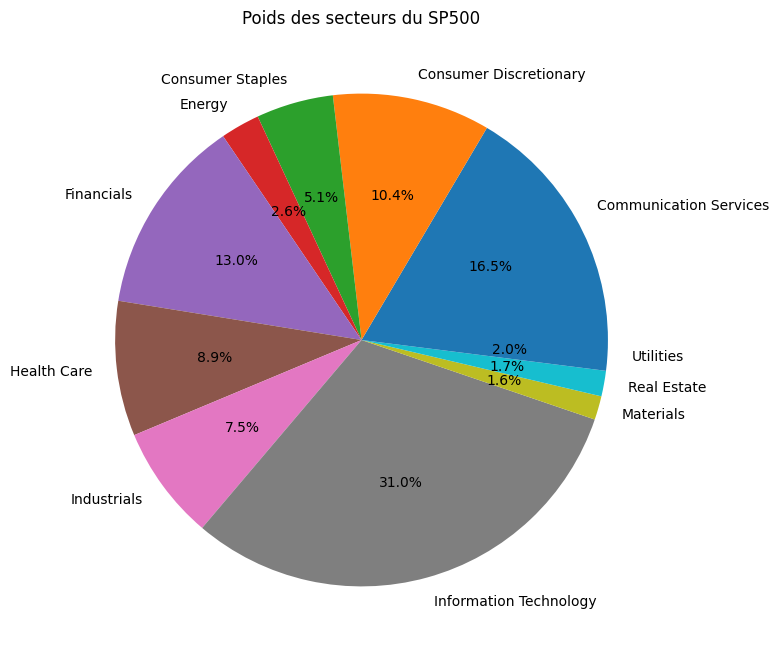

In [7]:
#Camembert Poids/Secteur
poids_secteurs=sp500.groupby("GICS Sector")["Poids (%)"].sum() # grouby pour avoir le poids total par secteur
plt.figure(figsize=(8,8))
plt.pie(poids_secteurs, labels=poids_secteurs.index,autopct="%1.1f%%") # autopct pour afficher les pourcentages et %1.1f%% pour 1 chiffre avant la virgule et 1 après
plt.title("Poids des secteurs du SP500")
plt.show()

Les secteurs principaux sont: La tech, les services telecom/medias, la finance, l'industrie, la santé et "consumers discretionary qu'on va analyser plus tard.


Ces domaines dépendent de:

-L'énergie (mix électrique USA: petrole/gaz/charbon/nucléaire)
- Les matières premières (Métaux/Métaux précieux)
- Les taux directeurs (FED)
- La bonne santé de l'économie américaine car en plus d'être affectés par l'économie, ces domaines dépendent des éventuelles subventions (dur à déterminer)



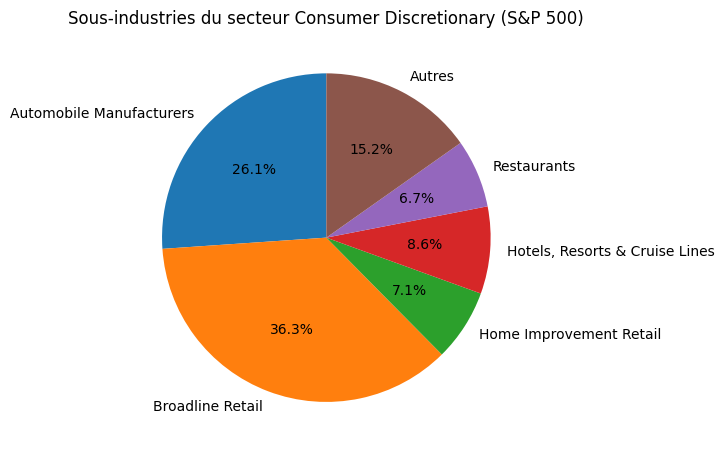

In [8]:
# on essaye de voir ce qu'il se passe dans le secteur Consumer Discretionary (car bcp de sous-industries : Automobiles, Hotels, broadling return Amazon)

consumer_disc = sp500[sp500["GICS Sector"] == "Consumer Discretionary"] # Filtrer les entreprises du secteur Consumer Discretionary
poids_secteurs_consumer_disc = consumer_disc.groupby("GICS Sub-Industry")["Poids (%)"].sum()

# Regrouper les sous-industries de moins de 0.5 % (par rapport au total) dans "Autres" pour avoir un camembert moins chargé
poids = poids_secteurs_consumer_disc.copy() 
autres = poids[poids < 0.5].sum()
poids = poids[poids >= 0.5]
poids["Autres"] = autres # Ajouter la catégorie "Autres" pour les sous-industries moins représentées

# Camembert plus lisible
plt.figure(figsize=(7,7))
plt.pie(
    poids,
    labels=poids.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Sous-industries du secteur Consumer Discretionary (S&P 500)")
plt.tight_layout()
plt.show()

On rajoute donc l'automobile qui rejoint l'industrie et les commerces (pas les supermarchés comme wallmart ect... car on est en dans des dépenses de confort)

In [9]:
#On prend aussi le top 10 du SP500:
top10 = sp500.sort_values("Poids (%)", ascending=False).head(10) # On récupère les 10 entreprises avec le plus de poids
top10

,Symbol,Security,GICS Sector,GICS Sub-Industry,MarketCap,Poids (%)
346,NVDA,Nvidia,Information Technology,Semiconductors,4.456719e+12,6.783508
38,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",4.038365e+12,6.146738
20,GOOG,Alphabet Inc. (Class C),Communication Services,Interactive Media & Services,3.747701e+12,5.704322
19,GOOGL,Alphabet Inc. (Class A),Communication Services,Interactive Media & Services,3.742585e+12,5.696535
316,MSFT,Microsoft,Information Technology,Systems Software,3.610364e+12,5.495284
22,AMZN,Amazon,Consumer Discretionary,Broadline Retail,2.433200e+12,3.703539
310,META,Meta Platforms,Communication Services,Interactive Media & Services,1.664178e+12,2.533022
439,TSLA,"Tesla, Inc.",Consumer Discretionary,Automobile Manufacturers,1.642722e+12,2.500364
71,AVGO,Broadcom,Information Technology,Semiconductors,1.616371e+12,2.460256
59,BRK.B,Berkshire Hathaway,Financials,Multi-Sector Holdings,1.077351e+12,1.639821


# III Ajout de nouvelles données

In [10]:
# Métaux
cuivre = clean_cols(yf.download("HG=F", start,end)) # Copper Futures
aluminium = clean_cols(yf.download("ALI=F", start, end))
nickel = clean_cols(yf.download("JJN", start, end))       #ETF JNN (à défaut d'avoir la donnée brute)
zinc = clean_cols(yf.download("ZINC.L", start, end))    #ETF

# Métaux précieux
Or = clean_cols(yf.download("GC=F", start, end))  #Valeur refuge, elle est corrélée aux crises sur les marchés. On l'importe ici par soucis de présentation
argent = clean_cols(yf.download("SI=F", start, end))

# Énergie
petrole = clean_cols(yf.download("CL=F", start, end))
gaz = clean_cols(yf.download("NG=F", start, end))
uranium = clean_cols(yf.download("URA", start, end))       # ETF Global x Uranium (à défaut d'avoir la donnée brute) (des centrales jusqu au minage) (etf sur energie nucléaire)


C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\877929508.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  cuivre = clean_cols(yf.download("HG=F", start,end)) # Copper Futures
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\877929508.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aluminium = clean_cols(yf.download("ALI=F", start, end))
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\877929508.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nickel = clean_cols(yf.download("JJN", start, end))       #ETF JNN (à défaut d'avoir la donnée brute)
[*********************100%***********************]  1 of 1 completed
C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\877929508.py:5: FutureWarning: YF.download() has changed argument auto_adjust

In [11]:
#On vérifie si tout est bien chargé
datasets = {
    "cuivre": cuivre,
    "aluminium": aluminium,
    "nickel": nickel,
    "zinc": zinc,
    "or": Or,
    "argent": argent,
    "petrole": petrole,
    "gaz": gaz,
    "uranium": uranium

}

for nom, df in datasets.items():
    if df is None or df.empty:
        print(f"{nom} : vide ou non chargé")


In [12]:
# Calcul des rendements pour chaque dataset
def rdm(df): 
    df["rendements"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
    return df.dropna(inplace=True) # dropna pour enlever les NaN générés par le shift (dropna cree un nouveau dataframe, inplace=True modifie le dataframe directement)


# Application de la fonction à tous les datasets
for nom, df in datasets.items():
    rdm(df)

Or["rendements"].head()

Date
2020-01-03    1.620200
2020-01-06    1.097341
2020-01-07    0.357560
2020-01-08   -0.916149
2020-01-09   -0.365999
Name: rendements, dtype: float64

In [13]:
#Pour ce qui est de la santé économique américaine, nous prendrons les obligations sur 10 ans.

oblig_10ans = clean_cols(yf.download("^TNX", start, end)) # ^TNX : Cours des obligations américaines à 10 ans


C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\3890274448.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oblig_10ans = clean_cols(yf.download("^TNX", start, end)) # ^TNX : Cours des obligations américaines à 10 ans
[*********************100%***********************]  1 of 1 completed


# IV Analyse de corrélation et features engineering

In [14]:
#On Rajoute la Moyenne mobile simple (SMA: Simple Moving Average) à ne pas confondre avec la vol_30j

def SMA(df, window):
    return df.rolling(window=window).mean()


#On rajoute également l'indice de force relative (RSI: Relative Strengh Index): il mesure la vitesse et l'amplitude des variations récente de prix, ce qui est utile pour savoir si on a une forte pression à la hausse ou baisse


def RSI(data, dt):
    delta = data.diff() # Calcule la différence entre les prix consécutifs
    gain = (delta.where(delta > 0, 0)).rolling(window=dt).mean() # Moyenne des gains sur la fenêtre dt
    loss = (-delta.where(delta < 0, 0)).rolling(window=dt).mean() # Moyenne des pertes sur la fenêtre dt

    rs = gain / loss # Relative Strength c'est le ratio des gains moyens sur les pertes moyennes
    rsi = 100 - (100 / (1 + rs)) # Formule du RSI
    return rsi




rsi=RSI(sp500_v["Volume"],14)   #Pour le moment on prend la valeur "standard" qui équivaut à 14 jours. Néanmoins, il serait peut être intéressant de prendre une échelle de temps plus courte pour refléter la "nervosité du marché". Nous optimiseront plus tard
sma=SMA(sp500_v["Volume"],14)   #Nous prendrons également une SMA à court terme (à la même fenêtre que la rsi pour une question de cohérence et également pour les raisons énoncées en haut)
#sma : rolling moyenne somme prix / n
#rsi : pression à la hausse ou à la baisse
sma.head() # plein de na pas le dataframe principal df donc on s'en occupe lors du merge
sma.tail()


Date
2023-11-24    3.621189e+09
2023-11-27    3.603164e+09
2023-11-28    3.588521e+09
2023-11-29    3.637754e+09
2023-11-30    3.744791e+09
Name: Volume, dtype: float64

On crée 13 valeurs manquantes car on calcule sur une fenêtre et on fait un rolling. L'optimal serait de faire toutes les transformations (rendements, vol_30j,rsi ect...) en même temps pour ne pas trop les accumuler. Néanmoins, par souci de présentation et de lisibilité, nous laisseront le notebook tel quel. Vu le grand nombre de données, la perte est négligeable.

# Il est temps de faire nos premières mesures de corrélations:

In [15]:
#On va faire des fonctions pour pouvoir avoir des matrices de corrélations avec un slider temporel
def ensure_data_range(start_year, end_year, df_dict):
    #On converti en timestamp les années en entrée (Timestamp car c'est la forme de notre index "Date")
    requested_start = pd.Timestamp(f"{start_year}-01-01")
    requested_end   = pd.Timestamp(f"{end_year}-12-31")

    #Pour chaque df:
    for name, df in df_dict.items():
        #On regarde si on a déjà téléchargé la data, sinon on le fait
        if requested_start < df.index.min() or requested_end > df.index.max():
            print(f"Téléchargement {name}…")
            df_new= clean_cols(
                yf.download(name, "2000-01-01", "2023-12-31")
            ).dropna()
            rdm(df_new)
            df_dict[name]=df_new
            

    return df_dict

_last_call = None
_initialized = False


def plot_corr(start_year, end_year, df_dict, rename_dict=None,title="Corrélation"):
    
    global _last_call, _initialized

    key = (
        min(start_year, end_year),
        max(start_year, end_year),
        title
    )

    # 🔹 Guard seulement APRES le premier affichage
    if _initialized and key == _last_call:
        return

    _last_call = key
    _initialized = True

    # On corrige si les dates ont été inversées
    if start_year > end_year:
        start_year, end_year = end_year, start_year

    df_dict = ensure_data_range(start_year, end_year, df_dict)


    df_concat = pd.concat(
        {i: j["Close"] for i, j in df_dict.items()},
        axis=1
    )
    #On prend la période demandée et on l'extrait de df_concat
    start = f"{start_year}-01-01"
    end   = f"{end_year}-12-31"
    
    final_df = df_concat.loc[start:end].dropna()

    #On fait attention à avoir assez de données
    if len(final_df) < 30:
        print("Intervalle trop court.")
        return

    corr = final_df.corr()

    # Renommage des variables
    if rename_dict:
        corr = corr.rename(index=rename_dict, columns=rename_dict)

    plt.close('all')  # empêche les doublons de graphes
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} ({start_year} => {end_year})")
    plt.tight_layout()
    plt.show()


    

#Même fonctions sur les rendements
def plot_corr_rdm(start_year, end_year, df_dict,rename_dict=None,title="Corrélation"):
    global _last_call
    key = (start_year, end_year)
    if key == _last_call:
        return
    _last_call = key
 
    if start_year > end_year:
        start_year, end_year = end_year, start_year

    df_dict = ensure_data_range(start_year, end_year, df_dict)

    df_concat = pd.concat(
        {i: j["rendements"] for i, j in df_dict.items()},
        axis=1
    )

    start = f"{start_year}-01-01"
    end   = f"{end_year}-12-31"
    
    final_df = df_concat.loc[start:end].dropna()

    if len(final_df) < 30:
        print("Intervalle trop court.")
        return

    corr = final_df.corr()

    
    if rename_dict:
        corr = corr.rename(index=rename_dict, columns=rename_dict)

    plt.close('all')  
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} ({start_year} => {end_year})")
    plt.tight_layout()
    plt.show()



A) Sur le prix de fermeture

In [16]:
#Il est temps d'évaluer nos théories:

#Corrélations entre les matières premières et le VIX:    
commos = {
    "^VIX": VIX,
    "HG=F": cuivre,
    "ALI=F": aluminium,
    "JJN": nickel,
    "ZINC.L": zinc,
    "GC=F": Or,
    "SI=F": argent,
  
}

rename_commo = {
    "^VIX": "VIX",
    "HG=F": "Cuivre",
    "GC=F": "Or",
    "SI=F": "Argent",
    "ZINC.L":"ETF ZINC",
    "ALI=F":"Aluminium",
    "JJN":"ETF Nickel"
}

#Utilisation de widgets
interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1,continuous_update=False),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1,continuous_update=False),
    df_dict=widgets.fixed(commos),
    rename_dict=widgets.fixed(rename_commo),
    title=widgets.fixed(value="Corrélation avec les Commodities (Close)")
)



interactive(children=(IntSlider(value=2020, continuous_update=False, description='start_year', max=2023, min=2…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On voit des corrélations intéressantes, notamment avec l'argent, l'or et l'aluminium (ainsi que le cuivre dans une moindre mesure).

Argent et Or étants eux mêmes très reliés (pareil pour le cuivre et l'aluminium), on va simplifier en ne gardant que l'argent et le cuivre.

B) Sur les rendements

In [17]:

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(commos),
    rename_dict=widgets.fixed(rename_commo),
    title=widgets.fixed(value="Corrélation avec les Commodities (Rendements)")
)


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On remarque que le prix de fermeture indique des corrélations intéressantes alors que le rendement en indique des quasi nulles: C'est tout à fait normal!

Le rendement qui représente les variations journalières est souvent chaotique, suivant une loi normale (voir visualisations en début de page). Ainsi, il n'est pas surprenant de ne rien trouver (ça serait trop beau :'( )

Néanmoins le prix (celui de cloture), bien que possédant une corrélation gonflée (due à une tendance commune puisqu'on est sur un marché global): mais ce n'est donc pas quelque chose à négligler. En plus, il contient de la donnée historique (présente plus ou moins dans la tête des investisseurs).

Néanmoins, cela va peut être biaiser le modèle. Nous corrigeront cela si nécessaire

# On fait de même avec l'énergie:

In [18]:
#Corrélations entre les matières premières et le VIX:
# Énergie

energies={
    "^VIX":VIX,
    "NG=F":gaz,
    "URA":uranium,
    "CL=F":petrole

}

rename_energies={
    "^VIX":"VIX",
    "NG=F":"Gaz",
    "URA":"ETF Uranium",
    "CL=F":"Petrole"

}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(energies),
    rename_dict=widgets.fixed(rename_energies),
    title=widgets.fixed(value="Corrélation avec l'énergie (Close)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

In [19]:
interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(energies),
    rename_dict=widgets.fixed(rename_energies),
    title=widgets.fixed(value="Corrélation avec l'énergie (Rendements)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On note un lien intéressant avec l'uranium, même dans les rendements!: Peut être parce que c'est un ETF sur l'industrie en elle même?

On le garde

In [20]:
#Corrélations entre les obligations et le VIX
rdm(oblig_10ans)

gouvernerment={
    "^VIX":VIX,
    "^TNX":oblig_10ans
    
}

rename_gouvernement={
    "^VIX":"VIX",
    "^TNX":"Obligations 10ans"

}




interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Corrélation avec les obligations US (Close)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

In [21]:

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Corrélation avec les obligations US (Rendements)")
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

On tient un filon, mais c'est pas trop ça. Essayons de prendre une maturité plus faible pour avoir une idée de l'impact des décisions récentes:

Prenons les 3 month treasury bills

In [22]:
oblig_3mois=clean_cols(yf.download("^IRX", start, end))
#Corrélations entre les obligations et le VIX
rdm(oblig_3mois)

gouvernerment={
    "^VIX":VIX,
    "^TNX":oblig_10ans,
    "^IRX":oblig_3mois
    
}

rename_gouvernement={
    "^VIX":"VIX",
    "^TNX":"Obligations 10ans",
    "^IRX":"Obligations 3mois"

}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(gouvernerment),
    rename_dict=widgets.fixed(rename_gouvernement),
    title=widgets.fixed(value="Corrélation avec les obligations US (Close)")
)

C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\48782524.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oblig_3mois=clean_cols(yf.download("^IRX", start, end))
[*********************100%***********************]  1 of 1 completed


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

L'oblig à court terme n'apporte rien visiblement

Avec le SP500:

In [23]:
#Corrélations entre le SP500 et le VIX:

#Ici SMA et RSI ne sont valables qu'à partir de l'année qu'on a choisi en start: à corriger
sp500_df = pd.DataFrame({
    "VIX": VIX["Close"],
    "SP500": sp500_v["Close"],
    "SP500 Vol": sp500_v["Volume"],
    "SP500 SMA": sma,
    "SP500 RSI": rsi
}).dropna()


interact(
    lambda start_year, end_year: sns.heatmap(
        sp500_df.loc[f"{start_year}-01-01":f"{end_year}-12-31"].corr(),
        annot=True, cmap="coolwarm", center=0
    ) or plt.title(f"Corrélation VIX / SP500 ({start_year} → {end_year})") or plt.show(),
    
    start_year=IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=IntSlider(value=2023, min=2000, max=2023, step=1)
)

interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.<lambda>(start_year, end_year)>

On importe également le VVIX (vol implice du VIX)

In [24]:
VVIX=clean_cols(yf.download("^VVIX", start, end))


VolImplciteVIX={
    "^VIX":VIX,
    "^VVIX":VVIX
}

rename_VolImpliciteVIX={
    "^VIX":"VIX",
    "^VVIX":"VVIX",

}

interact(
    plot_corr,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(VolImplciteVIX),
    rename_dict=widgets.fixed(rename_VolImpliciteVIX),
    title=widgets.fixed(value="Corrélation avec le VVIX (Close)")
)





C:\Users\cleme\AppData\Local\Temp\ipykernel_51216\1915750077.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VVIX=clean_cols(yf.download("^VVIX", start, end))
[*********************100%***********************]  1 of 1 completed


interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

In [25]:
rdm(VVIX)

interact(
    plot_corr_rdm,
    start_year=widgets.IntSlider(value=2020, min=2000, max=2023, step=1),
    end_year=widgets.IntSlider(value=2023, min=2000, max=2023, step=1),
    df_dict=widgets.fixed(VolImplciteVIX),
    rename_dict=widgets.fixed(rename_VolImpliciteVIX),
    title=widgets.fixed(value="Corrélation avec le VVIX (Rendements)")
)



interactive(children=(IntSlider(value=2020, description='start_year', max=2023, min=2000), IntSlider(value=202…

<function __main__.plot_corr_rdm(start_year, end_year, df_dict, rename_dict=None, title='Corrélation')>

En conclusion nous allons garder:

Matières premières: Aluminium, Or, Argent
Énergie: Uranium, Pétrole
Etat: Obligations 10 ans
SP500: Close, Volume, SMA, RSI
Autres indices: VVIX


## Premier modèle

In [26]:
rdm(VIX) #On crée la colonne manquante pour le vix
model1_df = pd.DataFrame({
    "VIX_Close": VIX["Close"],
    "VVIX_Close": VVIX["Close"],

    "SP500_Close": sp500_v["Close"],
    "SP500_Volume": sp500_v["Volume"],
    "SMA30": sma,
    "RSI14": rsi,

    "Or_Close": Or["Close"],
    "Argent_Close": argent["Close"],
    "Aluminium_Close": aluminium["Close"],

    "Uranium_Close": uranium["Close"],
    "Petrole_Close": petrole["Close"],

    "Taux10_Close": oblig_10ans["Close"],

    # Rendements (tirés des df sources)
    "SP500_ret": sp500_v["rendements"],
    "Or_ret": Or["rendements"],
    "Argent_ret": argent["rendements"],
    "Aluminium_ret": aluminium["rendements"],
    "Uranium_ret": uranium["rendements"],
    "Petrole_ret": petrole["rendements"],
    "Taux10_ret": oblig_10ans["rendements"],
    "VIX_ret": VIX["rendements"],
    "VVIX_ret": VVIX["rendements"],
})



model1_df = model1_df.dropna()
model1_df.head()

,VIX_Close,VVIX_Close,SP500_Close,SP500_Volume,SMA30,RSI14,Or_Close,Argent_Close,Aluminium_Close,Uranium_Close,...,Taux10_Close,SP500_ret,Or_ret,Argent_ret,Aluminium_ret,Uranium_ret,Petrole_ret,Taux10_ret,VIX_ret,VVIX_ret
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,39.619999,119.660004,3023.939941,5.579290e+09,5.263519e+09,60.940050,1666.400024,17.341999,1709.25,8.467398,...,0.926,-3.392208,1.541652,0.901837,-0.697168,-0.691025,-1.881140,-6.653224,23.851201,4.992544
2020-03-06,41.939999,127.160004,2972.370117,6.555240e+09,5.487486e+09,64.454742,1670.800049,17.214001,1675.25,8.374811,...,0.706,-1.705385,0.264044,-0.738083,-1.989177,-1.093447,-10.065365,-23.758102,5.855628,6.267758
2020-03-09,54.459999,137.190002,2746.560059,8.441290e+09,5.822549e+09,68.912728,1674.500000,17.000999,1660.75,7.558373,...,0.499,-7.596970,0.221448,-1.237372,-0.865542,-9.748730,-24.588178,-29.320109,29.852172,7.887699
2020-03-10,47.299999,138.820007,2882.229980,7.642040e+09,6.110252e+09,65.415256,1659.099976,16.906000,1686.00,7.886631,...,0.748,4.939631,-0.919679,-0.558787,1.520397,4.342972,10.375848,49.899801,-13.147264,1.188137
2020-03-11,53.900002,146.929993,2741.379883,7.431200e+09,6.353968e+09,63.255381,1641.400024,16.729000,1681.00,7.566790,...,0.820,-4.886845,-1.066841,-1.046966,-0.296560,-4.055488,-4.016301,9.625664,13.953493,5.842087


Certains actifs sont très corrélés entre eux (comme l'Or et l'Argent), nous allons donc procéder à une ACP:

In [27]:
print(model1_df[["Petrole_Close", "Uranium_Close"]].corr(),"\n")
print(model1_df[["Or_Close", "Argent_Close"]].corr())


               Petrole_Close  Uranium_Close
Petrole_Close       1.000000       0.824759
Uranium_Close       0.824759       1.000000 

              Or_Close  Argent_Close
Or_Close      1.000000      0.631597
Argent_Close  0.631597      1.000000


In [53]:
# Cible : VIX au jour suivant
model1_df["VIX_target"] = model1_df["VIX_Close"].shift(-1)
model1_df = model1_df.dropna()
y = model1_df["VIX_Close"]                     # cible
X = model1_df.drop(columns=["VIX_Close"])
#On split sans mélanger les données
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=False)# Shuffle=False pour ne pas biaiser le modèle (sinon on prédit le futur avec les données du futur..)




In [29]:
#ACP 1 : Or / Argent
metal_cols = ["Or_Close", "Argent_Close"]

# --- données train / test ---
df_metalp_train = X_train[metal_cols].dropna()
df_metalp_test  = X_test[metal_cols].dropna()

# --- standardisation (FIT SUR TRAIN) ---
scaler_metal = StandardScaler()
X_metal_scaled_train = scaler_metal.fit_transform(df_metalp_train)
X_metal_scaled_test  = scaler_metal.transform(df_metalp_test)

# --- ACP (FIT SUR TRAIN) ---
pca_metalp = PCA(n_components=2)
X_metal_pca_train = pca_metalp.fit_transform(X_metal_scaled_train)
X_metal_pca_test  = pca_metalp.transform(X_metal_scaled_test)

# --- variance expliquée (sur le train) ---
print("Variance expliquée:", pca_metalp.explained_variance_ratio_)

# --- corrélation descriptive (OK sur tout X) ---
df_metalp = X[metal_cols].dropna()
corr_metalp = df_metalp.corr().iloc[0, 1]

print(f"Corrélation Or-Argent : {corr_metalp:.3f}")
print(f"PC1 (facteur commun)  : {pca_metalp.explained_variance_ratio_[0]*100:.1f}% de la variance expliquée")
print(f"PC2 (écart Or vs Argent) : {pca_metalp.explained_variance_ratio_[1]*100:.1f}% de la variance expliquée")

Variance expliquée: [0.8517223 0.1482777]
Corrélation Or-Argent : 0.632
PC1 (facteur commun)  : 85.2% de la variance expliquée
PC2 (écart Or vs Argent) : 14.8% de la variance expliquée


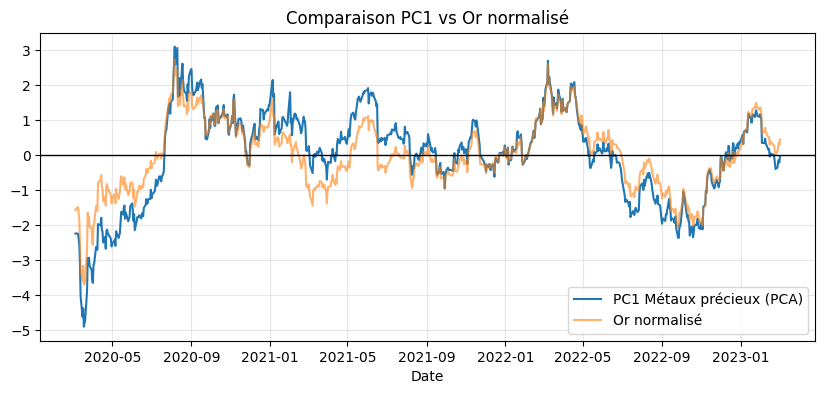

Corrélation PC2 / Spread standardisé : 0.411


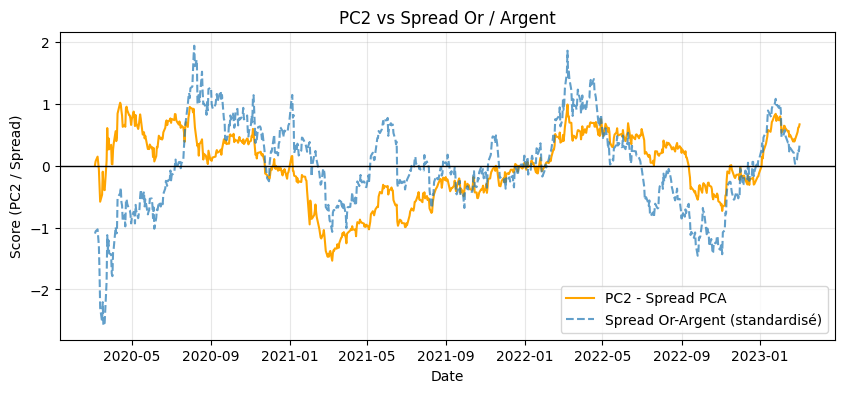

In [30]:
# PC1 et PC2 dans le temps
metal_pc1 = pd.Series(X_metal_pca_train[:, 0],index=df_metalp_train.index,name="Metal_PC1")
metal_pc2 = pd.Series(X_metal_pca_train[:, 1],index=df_metalp_train.index,name="Metal_PC2")


# PC1 vs Or (normalisé)
plt.figure(figsize=(10, 4))
plt.plot(metal_pc1, label="PC1 Métaux précieux (PCA)")
plt.plot(
    (df_metalp_train["Or_Close"] - df_metalp_train["Or_Close"].mean()) /
    df_metalp_train["Or_Close"].std(),
    label="Or normalisé", alpha=0.6
)
plt.axhline(0, color='black', linewidth=1)
plt.title("Comparaison PC1 vs Or normalisé")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.legend()
plt.show()



# PC2 vs Spread (Or-Argent)


# Spread standardisé
spread_std = (
    (df_metalp_train["Or_Close"] - df_metalp_train["Argent_Close"]) -
    (df_metalp_train["Or_Close"] - df_metalp_train["Argent_Close"]).mean()
) / (df_metalp_train["Or_Close"] - df_metalp_train["Argent_Close"]).std()

spread_std = spread_std / np.sqrt(2)  # même échelle que PC2 (dans notre ACP on divise par 1/2)
spread_std.name = "Spread Or-Argent"

# Corrélation
corr_pc2_spread = metal_pc2.corr(spread_std)
print(f"Corrélation PC2 / Spread standardisé : {corr_pc2_spread:.3f}")

# Plot comparaison
plt.figure(figsize=(10, 4))
plt.plot(metal_pc2, label="PC2 - Spread PCA", color="orange")
plt.plot(spread_std, label="Spread Or-Argent (standardisé)", linestyle="--", alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.title("PC2 vs Spread Or / Argent")
plt.xlabel("Date")
plt.ylabel("Score (PC2 / Spread)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [31]:
# ACP 2 : Pétrole/Uranium
energy_cols = ["Petrole_Close", "Uranium_Close"]

# --- données train / test ---
df_energy_train = X_train[energy_cols].dropna()
df_energy_test  = X_test[energy_cols].dropna()

# --- standardisation (FIT SUR TRAIN) ---
scaler_energy = StandardScaler()
X_energy_scaled_train = scaler_energy.fit_transform(df_energy_train)
X_energy_scaled_test  = scaler_energy.transform(df_energy_test)

# --- ACP (FIT SUR TRAIN) ---
pca_energy = PCA(n_components=2)
X_energy_pca_train = pca_energy.fit_transform(X_energy_scaled_train)
X_energy_pca_test  = pca_energy.transform(X_energy_scaled_test)

print("Variance expliquée (énergie) :", pca_energy.explained_variance_ratio_, "\n")

# Résultats
df_energy = X[energy_cols].dropna()
corr_energy = df_energy.corr().iloc[0, 1]

print(f"Corrélation Pétrole–Uranium : {corr_energy:.3f}")
print(f"PC1 (facteur ÉNERGIE commun)  : {pca_energy.explained_variance_ratio_[0]*100:.1f}% de la variance expliquée")
print(f"PC2 (écart Pétrole vs Uranium) : {pca_energy.explained_variance_ratio_[1]*100:.1f}% de la variance expliquée")


Variance expliquée (énergie) : [0.92361685 0.07638315] 

Corrélation Pétrole–Uranium : 0.825
PC1 (facteur ÉNERGIE commun)  : 92.4% de la variance expliquée
PC2 (écart Pétrole vs Uranium) : 7.6% de la variance expliquée


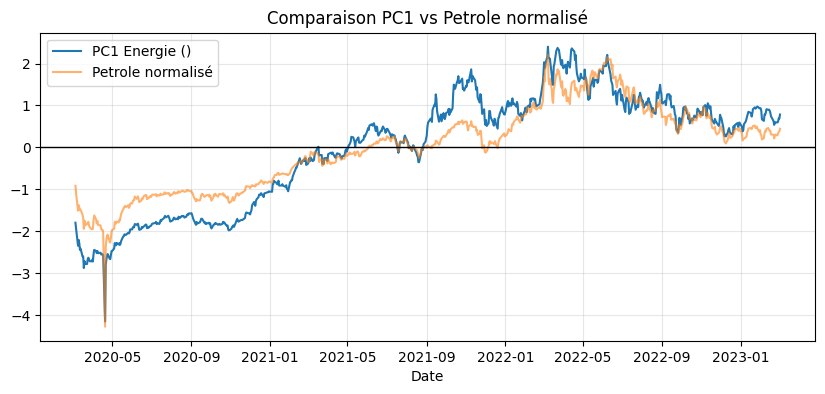

Corrélation PC2 / Spread standardisé : 0.397


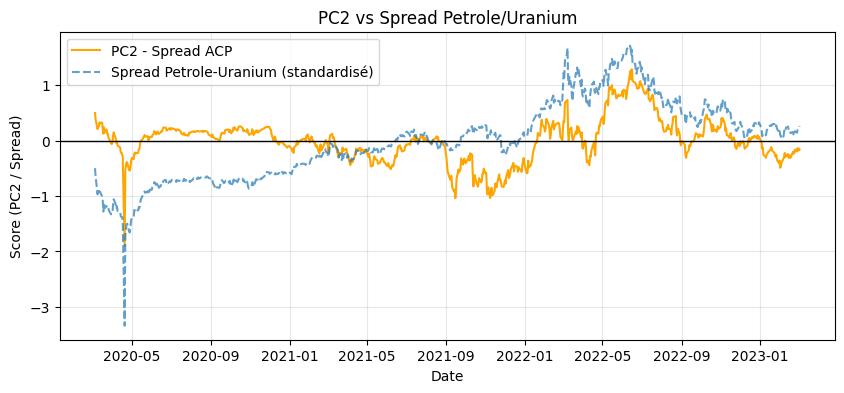

In [32]:
# PC1 et PC2 dans le temps
energie_pc1 = pd.Series(
    X_energy_pca_train[:, 0],
    index=df_energy_train.index,
    name="Energie_PC1"
)
energie_pc2 = pd.Series(
    X_energy_pca_train[:, 1],
    index=df_energy_train.index,
    name="Energie_PC2"
)

# PC1 vs Or (normalisé)
plt.figure(figsize=(10, 4))
plt.plot(energie_pc1, label="PC1 Energie ()")
plt.plot(
    (df_energy_train["Petrole_Close"] - df_energy_train["Petrole_Close"].mean()) /
    df_energy_train["Petrole_Close"].std(),
    label="Petrole normalisé", alpha=0.6
)
plt.axhline(0, color='black', linewidth=1)
plt.title("Comparaison PC1 vs Petrole normalisé")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.legend()
plt.show()



# PC2 vs Spread (Petrole vs Ura)


# Spread standardisé
spread_std = (
    (df_energy_train["Petrole_Close"] - df_energy_train["Uranium_Close"]) -
    (df_energy_train["Petrole_Close"] - df_energy_train["Uranium_Close"]).mean()
) / (df_energy_train["Petrole_Close"] - df_energy_train["Uranium_Close"]).std()

spread_std = spread_std / np.sqrt(2)  # même échelle que PC2 (dans notre ACP on divise par 1/2)
spread_std.name = "Spread Petrole-Uranium"

# Corrélation
corr_pc2_spread = energie_pc2.corr(spread_std)
print(f"Corrélation PC2 / Spread standardisé : {corr_pc2_spread:.3f}")

# Plot comparaison
plt.figure(figsize=(10, 4))
plt.plot(energie_pc2, label="PC2 - Spread ACP", color="orange")
plt.plot(spread_std, label="Spread Petrole-Uranium (standardisé)", linestyle="--", alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.title("PC2 vs Spread Petrole/Uranium")
plt.xlabel("Date")
plt.ylabel("Score (PC2 / Spread)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()




In [54]:
# Métaux : Or / Argent
metal_pc1 = pd.concat([pd.Series(X_metal_pca_train[:, 0], index=df_metalp_train.index),pd.Series(X_metal_pca_test[:, 0], index=df_metalp_test.index)]).sort_index()
metal_pc1.name = "Metal_PC1"

metal_pc2 = pd.concat([pd.Series(X_metal_pca_train[:, 1], index=df_metalp_train.index),pd.Series(X_metal_pca_test[:, 1], index=df_metalp_test.index)]).sort_index()
metal_pc2.name = "Metal_PC2"


# Énergie : Pétrole / Uranium
energy_pc1 = pd.concat([pd.Series(X_energy_pca_train[:, 0], index=df_energy_train.index),pd.Series(X_energy_pca_test[:, 0], index=df_energy_test.index)]).sort_index()
energy_pc1.name = "Energy_PC1"

energy_pc2 = pd.concat([pd.Series(X_energy_pca_train[:, 1], index=df_energy_train.index),pd.Series(X_energy_pca_test[:, 1], index=df_energy_test.index)]).sort_index()
energy_pc2.name = "Energy_PC2"


model1_df_acp = model1_df.copy()

# On remplace nos features par les nouvelles
model1_df_acp["Metal_PC1"] = metal_pc1
model1_df_acp["Metal_PC2"] = metal_pc2
model1_df_acp["Energy_PC1"] = energy_pc1
model1_df_acp["Energy_PC2"] = energy_pc2

cols_to_drop = ["Or_Close", "Argent_Close", "Petrole_Close", "Uranium_Close"]
model1_df_acp = model1_df_acp.drop(columns=cols_to_drop)

# Nettoyage des possibles valeurs nulles
model1_df_acp = model1_df_acp.dropna()

model1_df_acp.head()



,VIX_Close,VVIX_Close,SP500_Close,SP500_Volume,SMA30,RSI14,Aluminium_Close,Taux10_Close,SP500_ret,Or_ret,...,Uranium_ret,Petrole_ret,Taux10_ret,VIX_ret,VVIX_ret,VIX_target,Metal_PC1,Metal_PC2,Energy_PC1,Energy_PC2
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,39.619999,119.660004,3023.939941,5.579290e+09,5.263519e+09,60.940050,1709.25,0.926,-3.392208,1.541652,...,-0.691025,-1.881140,-6.653224,23.851201,4.992544,41.939999,-2.235205,0.013683,-1.792505,0.499457
2020-03-06,41.939999,127.160004,2972.370117,6.555240e+09,5.487486e+09,64.454742,1675.25,0.706,-1.705385,0.264044,...,-1.093447,-10.065365,-23.758102,5.855628,6.267758,54.459999,-2.226929,0.075046,-1.937027,0.381162
2020-03-09,54.459999,137.190002,2746.560059,8.441290e+09,5.822549e+09,68.912728,1660.75,0.499,-7.596970,0.221448,...,-9.748730,-24.588178,-29.320109,29.852172,7.887699,47.299999,-2.241819,0.148496,-2.341367,0.208097
2020-03-10,47.299999,138.820007,2882.229980,7.642040e+09,6.110252e+09,65.415256,1686.00,0.748,4.939631,-0.919679,...,4.342972,10.375848,49.899801,-13.147264,1.188137,53.900002,-2.383388,0.046327,-2.203001,0.253477
2020-03-11,53.900002,146.929993,2741.379883,7.431200e+09,6.353968e+09,63.255381,1681.00,0.820,-4.886845,-1.066841,...,-4.055488,-4.016301,9.625664,13.953493,5.842087,75.470001,-2.560162,-0.057038,-2.287554,0.259526


In [55]:
# Séparation finale X / y après ACP (prédiction de VIX à t+1)
y_acp = model1_df_acp["VIX_target"]
X_acp = model1_df_acp.drop(columns=["VIX_Close", "VIX_target"])

# Réalignement avec le split initial (split temporel conservé)
X_train_acp = X_acp.loc[X_train.index.intersection(X_acp.index)]
X_test_acp  = X_acp.loc[X_test.index.intersection(X_acp.index)]

y_train_acp = y_acp.loc[X_train_acp.index]
y_test_acp  = y_acp.loc[X_test_acp.index]

# Standardisation (fit sur le train uniquement)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_acp)
X_test_scaled  = scaler.transform(X_test_acp)




In [56]:
model1_linear = LinearRegression()
model1_linear.fit(X_train_scaled, y_train_acp)

y_pred_linear1 = model1_linear.predict(X_test_scaled)

MSE_linear1 = mean_squared_error(y_test_acp, y_pred_linear1)
print("MSE Regression linéaire: ", MSE_linear1, "\n")

RMSE_linear1 = np.sqrt(mean_squared_error(y_test_acp, y_pred_linear1))
print("RMSE :", RMSE_linear1, "\n")

R2_linear1 = r2_score(y_test_acp, y_pred_linear1)
print("R2 score: ", R2_linear1)




MSE Regression linéaire:  6.712555215878081 

RMSE : 2.5908599375261643 

R2 score:  0.203957124775619


In [57]:
model1_forestreg = RandomForestRegressor()
model1_forestreg.fit(X_train_scaled, y_train_acp)

y_pred_forestreg1 = model1_forestreg.predict(X_test_scaled)

MSE_forestreg1 = mean_squared_error(y_test_acp, y_pred_forestreg1)
print("MSE Random Forest Reg: ", MSE_forestreg1, "\n")

RMSE_forestreg1 = np.sqrt(mean_squared_error(y_test_acp, y_pred_forestreg1))
print("RMSE :", RMSE_forestreg1, "\n")

R2_forestreg1 = r2_score(y_test_acp, y_pred_forestreg1)
print("R2 score: ", R2_forestreg1)




MSE Random Forest Reg:  28.049196798303946 

RMSE : 5.2961492424500225 

R2 score:  -2.3263582270787424


Modèle pourri: Overfitting probable :'( 

In [58]:
model1_gradient = GradientBoostingRegressor()
model1_gradient.fit(X_train_scaled, y_train_acp)

y_pred_gradient1 = model1_gradient.predict(X_test_scaled)

MSE_gradient1 = mean_squared_error(y_test_acp, y_pred_gradient1)
print("MSE Gradient Boosting: ", MSE_gradient1, "\n")

RMSE_gradient1 = np.sqrt(mean_squared_error(y_test_acp, y_pred_gradient1))
print("RMSE :", RMSE_gradient1, "\n")

R2_gradient1 = r2_score(y_test_acp, y_pred_gradient1)
print("R2 score: ", R2_gradient1)


MSE Gradient Boosting:  18.55840935467235 

RMSE : 4.307947232113266 

R2 score:  -1.2008443978738885


#Nos modèles sont très mauvais, même pas la peine de faire de la recherche d'hyperparamètres. 

Nous allons améliorer le modèle: comme il s'agit d'une série temporelle, il serait intéressant d'ajouter un "historique" des prix passés.

New Model:

In [61]:
model2_df = model1_df_acp.copy()
#Ici nous allons ajouter un "historique" qui donnera les prix passés dans chaque colonne sur 1,5,10 et 30 jours

#VIX
for lag in [1, 5, 10, 30]:
    model2_df[f"VIX_lag_{lag}"] = model2_df["VIX_Close"].shift(lag)

#Rendements SP500
for lag in [1, 5, 10, 30]:
    model2_df[f"SP500_ret_lag_{lag}"] = model2_df["SP500_ret"].shift(lag)

#Volatilité réalisée
for window in [5, 10, 20, 30]:
    model2_df[f"RV_{window}"] = model2_df["SP500_ret"].rolling(window).std()

#VVIX
for lag in [1, 5, 10, 30]:
    model2_df[f"VVIX_lag_{lag}"] = model2_df["VVIX_Close"].shift(lag)

#SP500 drawdown (pire perte): comme notre VIX est l'indice de la peur cela est très pertinent
rolling_max = model2_df["SP500_Close"].rolling(30).max()
model2_df["SP500_drawdown_30"] = model2_df["SP500_Close"] / rolling_max - 1

model2_df = model2_df.dropna()

#Commos (via ACP)
commos_cols = ["Metal_PC1", "Metal_PC2", "Energy_PC1", "Energy_PC2"]

# Lags des commodities
for col in commos_cols:
    for lag in [1, 5, 10, 30]:
        model2_df[f"{col}_lag_{lag}"] = model2_df[col].shift(lag)








In [62]:
#Nous allons également rajouter les moyennes sur les 5 derniers jours (1 semaine de marché) qui donnnent une info différente:
#VIX
model2_df["VIX_MA_5"] = model2_df["VIX_Close"].rolling(5).mean()

#rendements
# On utilise pas notre fonction rdm. Nous prenons les log-rendements car les % “classiques” ne s’additionnent pas bien : +100% puis −50% ramène au point de départ, et les log-rendements reflètent correctement ce “0 net” quand on les additionne.
model2_df["SP500_log_ret"] = np.log(model2_df["SP500_Close"]).diff()
model2_df["SP500_log_ret_MA_5"] = model2_df["SP500_log_ret"].rolling(5).mean()

#Commos (via ACP)
model2_df["Metal_PC1_MA_5"] = model2_df["Metal_PC1"].rolling(5).mean()
model2_df["Metal_PC2_MA_5"] = model2_df["Metal_PC2"].rolling(5).mean()
model2_df["Energy_PC1_MA_5"] = model2_df["Energy_PC1"].rolling(5).mean()
model2_df["Energy_PC2_MA_5"] = model2_df["Energy_PC2"].rolling(5).mean()

model2_df = model2_df.dropna()
model2_df.head()



,VIX_Close,VVIX_Close,SP500_Close,SP500_Volume,SMA30,RSI14,Aluminium_Close,Taux10_Close,SP500_ret,Or_ret,...,Energy_PC2_lag_5,Energy_PC2_lag_10,Energy_PC2_lag_30,VIX_MA_5,SP500_log_ret,SP500_log_ret_MA_5,Metal_PC1_MA_5,Metal_PC2_MA_5,Energy_PC1_MA_5,Energy_PC2_MA_5
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,28.230000,106.470001,3055.729980,4.684170e+09,5.529729e+09,49.483730,1535.75,0.662,0.375123,0.051818,...,0.074079,-0.005964,-0.292398,27.992,0.003744,0.006674,-1.655000,0.291624,-2.001052,0.051528
2020-06-02,26.840000,104.830002,3080.820068,5.197150e+09,5.535266e+09,50.290514,1557.25,0.680,0.821083,-0.725060,...,0.080332,0.029828,-1.899082,27.758,0.008177,0.005866,-1.596086,0.297285,-1.976090,0.054555
2020-06-03,25.660000,106.849998,3122.870117,6.005560e+09,5.524831e+09,49.443180,1572.50,0.761,1.364898,-1.588216,...,0.010302,0.061091,-0.535687,27.366,0.013557,0.005634,-1.606124,0.267755,-1.944644,0.074079
2020-06-04,25.809999,109.879997,3112.350098,6.451290e+09,5.581986e+09,53.062588,1569.25,0.820,-0.336870,1.242783,...,0.034709,0.072560,-0.448721,26.810,-0.003374,0.005381,-1.591910,0.271268,-1.920973,0.092505
2020-06-05,24.520000,107.589996,3193.929932,8.639300e+09,5.805671e+09,60.364018,1596.75,0.904,2.621165,-2.484151,...,0.067456,0.102673,-0.386853,26.212,0.025874,0.009596,-1.729331,0.216547,-1.895493,0.113217


Déploiement des modèles:

Les modèles non linéaires (Random Forest et Gradient Boosting) ont été écartés car ils présentent de mauvaises performances hors échantillon, probablement en raison du bruit élevé et de la faible structure non linéaire exploitable du VIX, conduisant probablement à un sur-apprentissage.

In [63]:
# Séparation X / y pour le Modèle 2 (prédiction de VIX(t+1))
y_model2 = model2_df["VIX_target"]
X_model2 = model2_df.drop(columns=["VIX_Close", "VIX_target"])

# Réalignement avec le split temporel initial
X_train_2 = X_model2.loc[X_train.index.intersection(X_model2.index)]
X_test_2  = X_model2.loc[X_test.index.intersection(X_model2.index)]

y_train_2 = y_model2.loc[X_train_2.index]
y_test_2  = y_model2.loc[X_test_2.index]

# Standardisation (fit sur train uniquement)
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2  = scaler.transform(X_test_2)



In [80]:
model2_linear = LinearRegression()
model2_linear.fit(X_train_scaled_2, y_train_2)

y_pred_linear2 = model2_linear.predict(X_test_scaled_2)

MSE_linear2 = mean_squared_error(y_test_2, y_pred_linear2)
print("MSE Regression linéaire (Model 2): ", MSE_linear2, "\n")

RMSE_linear2 = np.sqrt(mean_squared_error(y_test_2, y_pred_linear2))
print("RMSE :", RMSE_linear2, "\n")

R2_linear2 = r2_score(y_test_2, y_pred_linear2)
print("R2 score: ", R2_linear2)



MSE Regression linéaire (Model 2):  1.9885275273838223 

RMSE : 1.410151597305702 

R2 score:  0.7641802384556805


Les features ajoutées n’améliorent pas la régression linéaire car l’information temporelle est déjà capturée par les indicateurs de volatilité et de niveau.


In [79]:
model2_ridge = Ridge(alpha=1.0)
model2_ridge.fit(X_train_scaled_2, y_train_2)

y_pred_ridge2 = model2_ridge.predict(X_test_scaled_2)

MSE_ridge2 = mean_squared_error(y_test_2, y_pred_ridge2)
print("MSE Ridge Regression (Model 2): ", MSE_ridge2, "\n")

RMSE_ridge2 = np.sqrt(mean_squared_error(y_test_2, y_pred_ridge2))
print("RMSE :", RMSE_ridge2, "\n")

R2_ridge2 = r2_score(y_test_2, y_pred_ridge2)
print("R2 score: ", R2_ridge2)



MSE Ridge Regression (Model 2):  2.101812616800527 

RMSE : 1.4497629519340487 

R2 score:  0.7507457436323068


In [78]:
model2_lasso = Lasso(alpha=0.01, max_iter=10000)
model2_lasso.fit(X_train_scaled_2, y_train_2)

y_pred_lasso2 = model2_lasso.predict(X_test_scaled_2)

MSE_lasso2 = mean_squared_error(y_test_2, y_pred_lasso2)
print("MSE Lasso Regression (Model 2): ", MSE_lasso2, "\n")

RMSE_lasso2 = np.sqrt(mean_squared_error(y_test_2, y_pred_lasso2))
print("RMSE :", RMSE_lasso2, "\n")

R2_lasso2 = r2_score(y_test_2, y_pred_lasso2)
print("R2 score: ", R2_lasso2)



MSE Lasso Regression (Model 2):  2.4546577625044605 

RMSE : 1.5667347454194218 

R2 score:  0.7089017877523278


In [82]:
# Features les plus utiles (Modèle 2)
coef_lasso2 = pd.Series(model2_lasso.coef_, index=X_train_2.columns)
coef_lasso2[coef_lasso2 != 0].sort_values(key=abs, ascending=False)



VIX_lag_1             3.885425
VIX_ret               1.076322
SP500_log_ret        -0.997535
SP500_ret             0.696932
VIX_MA_5              0.481912
Energy_PC2_lag_10    -0.298151
Metal_PC2_lag_30      0.297677
RV_10                -0.228384
SP500_drawdown_30    -0.222974
Energy_PC1_lag_10    -0.190261
Energy_PC2_MA_5       0.168200
Energy_PC2_lag_5      0.156648
Aluminium_Close       0.124670
VIX_lag_30            0.123970
SP500_log_ret_MA_5    0.122283
VVIX_ret              0.107213
VVIX_lag_5           -0.103565
SP500_Volume          0.101164
SMA30                -0.100682
SP500_ret_lag_30      0.074780
Energy_PC2_lag_30    -0.071863
Energy_PC1_lag_1      0.070497
Petrole_ret           0.070135
SP500_ret_lag_10     -0.069838
Metal_PC1_lag_10     -0.067677
Taux10_ret           -0.063918
SP500_ret_lag_5       0.052050
Aluminium_ret         0.046012
Or_ret               -0.045714
Argent_ret            0.045388
Energy_PC2            0.041247
VVIX_lag_10          -0.036327
VVIX_Clo

Le modèle est déjà bon mais il manque une mesure de choc ou de surprise de volatilité, car le VIX réagit vraissemblablement davantage aux variations soudaines de l’incertitude (ce qui est cohérent vu son côté psychologique) que sur des metrics de fond et de long terme.



In [83]:
model3_df=model2_df.copy()

In [69]:
# 1) Choc sur la volatilité
#Le VIX réagit davantage aux variations soudaines qu’au niveau moyen de volatilité
model3_df["RV_surprise_10"] = model3_df["RV_10"] - model3_df["RV_30"]
#L'accélération permet de mieux capturer la panique que la vitesse
model3_df["RV_acceleration"] = model3_df["RV_5"] - model3_df["RV_10"]

# 2) Chocs de marché actions

# Journée de choc : quand on a perdu plus de 2%.
model3_df["SP500_crash_day"] = (model3_df["SP500_log_ret"] < -0.02).astype(int)

# Accumulation de jours négatifs récents : pression psychologique du marché
model3_df["SP500_neg_days_5"] = (model3_df["SP500_log_ret"] < 0).rolling(5).sum()
model3_df = model3_df.dropna()


In [73]:
# Cible : VIX(t+1)
y_model3 = model3_df["VIX_target"]
X_model3 = model3_df.drop(columns=["VIX_Close", "VIX_target"])

# Réalignement avec le split temporel initial
X_train_3 = X_model3.loc[X_train.index.intersection(X_model3.index)]
X_test_3  = X_model3.loc[X_test.index.intersection(X_model3.index)]

y_train_3 = y_model3.loc[X_train_3.index]
y_test_3  = y_model3.loc[X_test_3.index]

# Standardisation (fit sur train uniquement)
scaler = StandardScaler()
X_train_scaled_3 = scaler.fit_transform(X_train_3)
X_test_scaled_3  = scaler.transform(X_test_3)



In [84]:
model3_linear = LinearRegression()
model3_linear.fit(X_train_scaled_3, y_train_3)

y_pred_linear3 = model3_linear.predict(X_test_scaled_3)

MSE_linear3 = mean_squared_error(y_test_3, y_pred_linear3)
print("MSE Regression linéaire (Model 3): ", MSE_linear3, "\n")

RMSE_linear3 = np.sqrt(mean_squared_error(y_test_3, y_pred_linear3))
print("RMSE :", RMSE_linear3, "\n")

R2_linear3 = r2_score(y_test_3, y_pred_linear3)
print("R2 score: ", R2_linear3)


MSE Regression linéaire (Model 3):  1.6813224665596618 

RMSE : 1.2966581918762021 

R2 score:  0.8006117301957385


In [76]:
model3_lasso = Lasso(alpha=0.01, max_iter=10000)
model3_lasso.fit(X_train_scaled_3, y_train_3)

y_pred_lasso3 = model3_lasso.predict(X_test_scaled_3)

MSE_lasso3 = mean_squared_error(y_test_3, y_pred_lasso3)
print("MSE Lasso Regression (Model 3): ", MSE_lasso3, "\n")

RMSE_lasso3 = np.sqrt(mean_squared_error(y_test_3, y_pred_lasso3))
print("RMSE :", RMSE_lasso3, "\n")

R2_lasso3 = r2_score(y_test_3, y_pred_lasso3)
print("R2 score: ", R2_lasso3)


MSE Lasso Regression (Model 3):  2.11903894005124 

RMSE : 1.455691911103184 

R2 score:  0.7487028715144572


In [85]:
model3_ridge = Ridge(alpha=1.0)
model3_ridge.fit(X_train_scaled_3, y_train_3)

y_pred_ridge3 = model3_ridge.predict(X_test_scaled_3)

MSE_ridge3 = mean_squared_error(y_test_3, y_pred_ridge3)
print("MSE Ridge Regression (Model 3): ", MSE_ridge3, "\n")

RMSE_ridge3 = np.sqrt(mean_squared_error(y_test_3, y_pred_ridge3))
print("RMSE :", RMSE_ridge3, "\n")

R2_ridge3 = r2_score(y_test_3, y_pred_ridge3)
print("R2 score: ", R2_ridge3)


MSE Ridge Regression (Model 3):  1.7298758282606048 

RMSE : 1.3152474399369134 

R2 score:  0.7948537801443478


#Etude et sélection des modèles
